In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
%env DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
env: DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
Wed Mar  6 09:50:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1A:00.0 Off |                  N/A |
| 30%   33C    P8               6W / 250W |      2MiB / 11264MiB |      0%      Default |
|                             

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[09:50:27.635] INFO   CaloQVAE                                          Willkommen!
[09:50:27.637] INFO   CaloQVAE                                          Loading configuration.


In [3]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2024-03-06 09:50:29,916 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[09:50:29.916] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [5]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[09:50:34.626] INFO   data.dataManager                                  Loading Data
[09:50:40.442] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b23be4f10>: 12739 events, 100 batches
[09:50:40.446] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b23be4fd0>: 1592 events, 2 batches
[09:50:40.447] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b23be4c40>: 1593 events, 13 batches
[09:50:41.737] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-03-06 09:50:41,742 dwave.cloud

Initializing NetworkV3


In [6]:


dev = torch.device("cuda:0")
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[09:50:47.790] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[09:50:49.462] INFO   engine.engineAtlas                                Setting up engine Atlas.
[09:50:49.463] INFO   engine.engineCaloV3                               Setting up engine Calo.
[09:50:49.464] INFO   engine.engine                                     Setting up default engine.


In [7]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[09:50:55.372] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c0608c2e0>: 12739 events, 100 batches
[09:50:55.373] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b86efdeb0>: 1592 events, 2 batches
[09:50:55.373] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b86efdfa0>: 1593 events, 13 batches


In [8]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [9]:
# winter-snowflake-24: GumBoltAtlasPRBMCNN
# run_path = "/fast_scratch/sgonzalez/wandb/run-20231212_114037-6opefab5/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"

run_path = "/fast_scratch/QVAE/models/GumBoltAtlasPRBMCNN_atlas_robust_tree_best.pth"
modelname = 'macabre-candle-1372'
datascaled = 'scaled'
with open("/fast_scratch/QVAE/models/robust-tree_config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    #R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    #reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasPRBMCNN
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [10]:
xtarget_samples = []
xrecon_samples = []
xgen_samples = []
scaled = True
entarget_samples = []

def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v
            
for xx in train_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
    fwd_output = engine.model((in_data, true_energy), False)
    
    if scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        
        
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        
        ## This is how youi generate data using model
        # ================================
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples_qpu(num_samples=128, true_energy=true_energy[:128])
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        # ================================
    
    else:
        raise Exception("Script only supports scaled dataset at the moment...")


    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

In [11]:
events = xgen_samples.numpy()
energies = entarget_samples.numpy()

print(events.shape)
print(energies.shape)

(12739, 6480)
(12739, 1)


In [12]:
import h5py

#file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_synthetic_no_fixes.hdf5"
#file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_synthetic_bitmask_fix.hdf5"
#file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_synthetic_bitmask_and_bce_fixes.hdf5"
#file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_synthetic_bitmask_and_bce_fixes_full_data_training.hdf5"
file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_synthetic_robust_tree.hdf5"

#file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_synthetic_fixes_nonchi.hdf5"
#file_path = "/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_synthetic_fixes_chi.hdf5"


d = {"showers":events, "incident_energies":energies}

h = h5py.File(file_path, "w")
for k, v in d.items():
    h.create_dataset(k, data=v)

In [13]:
uniform_data=h5py.File(file_path,'r')

events = np.array(uniform_data["showers"])
energies = np.array(uniform_data["incident_energies"])

print(events.shape)
print(energies.shape)

(12739, 6480)
(12739, 1)


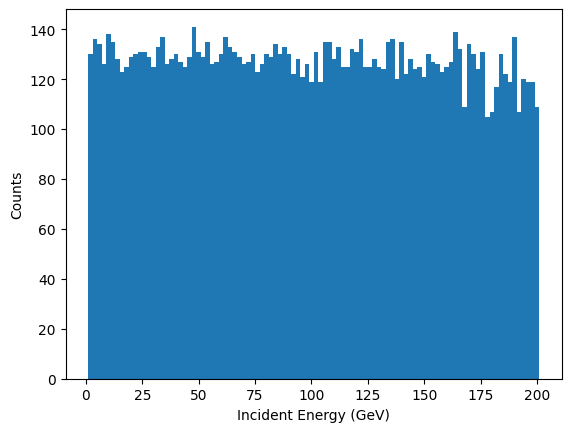

In [14]:
counts = plt.hist(energies / 1000 , log=False, bins=100)
plt.xlabel("Incident Energy (GeV)");
plt.ylabel("Counts");

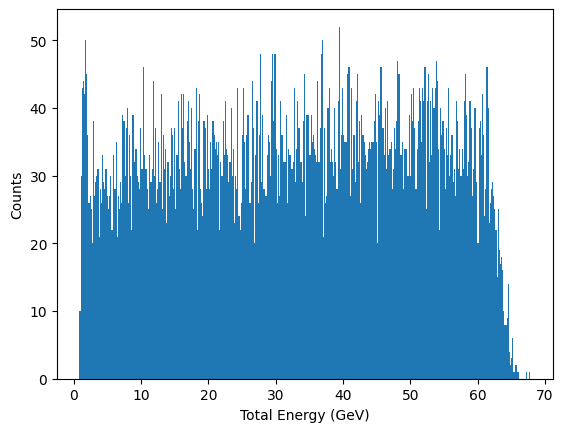

In [15]:
counts = plt.hist(events.sum(axis=1) / 1000 , log=False, bins=400)
plt.xlabel("Total Energy (GeV)");
plt.ylabel("Counts");

In [ ]:
plt.scatter()